# Code to implement battery operation scheduling for 2019

In [20]:
#import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import gurobipy
from datetime import datetime, time, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [21]:
#12-31-2018 23:45:00 is current max peak for period 1
def run_daily_optimization(D, P, battery, month, e_0, current_max_peak):
    """
    Description: Code to run the optimization procedure

    Inputs:
        D, np.array: demand for each period
        P, float: battery power rating
        battery, str : battery option either "li-ion" or "thermal"
        month, int: month of year
        e_0, float: energy stored in the battery and the start of the month
        current_max_peak, float: max peak for the previous day
    
    Output:
        Results of optimization
    """
    #Update variables depending on battery type
    if battery == 'li-ion':
        #battery efficiency
        eta = .95
        #Energy rating
        E = 4*P
        #Define additional variables
        cost_P = 300*P
        cost_E = 200*E

    elif battery == 'thermal':
        #battery efficiency
        eta = .7
        #Energy rating
        E = 12*P
        #Define additional variables
        cost_P = 500*P
        cost_E = 50*E

    else:
        print('optimizing without battery...')
        P=0
        eta = 1
        E = 0
        cost_P = 0
        cost_E = 0
    
    #Update peak charges depending on time of year:
    if month in [6, 7, 8, 9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
        
    #Cost of electricity
    C = .13
    
    # Decision Variables
    #Storage discharge power
    d = cp.Variable(len(D), nonneg=True)
    # Storage charge power
    q = cp.Variable(len(D), nonneg=True)
    # Energy storged
    e = cp.Variable(len(D), nonneg=True)
    # peak demand
    p = cp.Variable(nonneg=True)

    # Initialize an empty constraint set
    con_set_1 = []  

    for t in range(len(D)):
        #These if statements relate to if a charge/discharge is provided
        #Can't discharge more than the power rating of battery
        con_set_1.append(d[t] <= .25*P)
        #Can't charge more than the power rating of battery
        con_set_1.append(q[t] <= .25*P)
        # #Can't store more energy than capacity
        con_set_1.append(e[t] <= E)
        if t == 0:
            # state-of charge constraint 1 - assume battery is empty
            # before month starts
            con_set_1.append(e[t] - e_0 == q[t]*eta - d[t]/eta)
        elif t == len(D)-1:
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t])
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
        else:
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])
            
    op_cost = 2*B*p + C*sum(D - d + q)
    #Define Objective - BP + sum over t
    #mutlipy by 2 because p is only a half hour increment right now
    obj = cp.Minimize(2*B*p + C*sum(D - d + q) + 10000*(p- current_max_peak))

    # Solve the problem
    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI", reoptimize=True)
    prob1.solve();

    return(prob1.value, cost_E, cost_P, e, p, d, q, op_cost)

## Data pre-processing

In [22]:
#Add date parser to read in the date as an actual date object
date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
demand = pd.read_csv('./data/ColumbiaDemand.csv', parse_dates=['Date'], date_parser=date_parser) 
demand.head()
#Restructure into one list of demands for each month

,Date,TotalDemand [kWh],Period01 [kWh],Period02 [kWh],Period03 [kWh],Period04 [kWh],Period05 [kWh],Period06 [kWh],Period07 [kWh],Period08 [kWh],...,Period87 [kWh],Period88 [kWh],Period89 [kWh],Period90 [kWh],Period91 [kWh],Period92 [kWh],Period93 [kWh],Period94 [kWh],Period95 [kWh],Period96 [kWh]
0,2018-01-01,72686.88,734.40,731.52,727.20,735.84,730.08,728.64,731.52,730.08,...,740.16,741.60,734.40,735.84,735.84,730.08,725.76,731.52,728.64,724.32
1,2018-01-02,73594.08,728.64,727.20,728.64,727.20,732.96,734.40,734.40,737.28,...,743.04,741.60,741.60,738.72,750.24,743.04,750.24,738.72,738.72,743.04
2,2018-01-03,73440.00,745.92,743.04,745.92,744.48,741.60,734.40,735.84,734.40,...,734.40,732.96,721.44,714.24,721.44,725.76,727.20,724.32,731.52,722.88
3,2018-01-04,73967.04,718.56,718.56,724.32,727.20,720.00,724.32,725.76,720.00,...,747.36,744.48,735.84,734.40,741.60,743.04,738.72,741.60,740.16,735.84
4,2018-01-05,74625.12,745.92,743.04,744.48,741.60,737.28,743.04,747.36,748.80,...,767.52,768.96,760.32,758.88,756.00,756.00,753.12,754.56,750.24,745.92


In [23]:
#Drop total demand columns and pivot
demand_unpivoted = demand[demand.columns.difference(['TotalDemand [kWh]'])].melt(id_vars=['Date'], var_name='period', value_name='demand')
#Make sure to sort by date and period
demand_unpivoted = demand_unpivoted.sort_values(by=['Date','period']).reset_index(drop=True)
demand_unpivoted['year'] = demand_unpivoted['Date'].dt.year
demand_unpivoted['month'] = demand_unpivoted['Date'].dt.month
demand_unpivoted['day'] = demand_unpivoted['Date'].dt.day
demand_unpivoted = demand_unpivoted.fillna(0)
#Find the rolling demand
demand_unpivoted['rolling_demand'] = demand_unpivoted[['demand']].rolling(2).sum()
# Just take 2019 demand
demand_2019 = demand_unpivoted[demand_unpivoted['year'] ==2019].reset_index(drop=True)
demand_2019['period'] = demand_2019['period'].apply(lambda x: (int(x.split()[0].split('d')[1])-1)*15)
demand_2019['timestamp'] = demand_2019['Date'] + pd.TimedeltaIndex(demand_2019['period'], unit='m')
demand_2019.head()

,Date,period,demand,year,month,day,rolling_demand,timestamp
0,2019-01-01,0,666.72,2019,1,1,1336.32,2019-01-01 00:00:00
1,2019-01-01,15,665.28,2019,1,1,1332.00,2019-01-01 00:15:00
2,2019-01-01,30,679.68,2019,1,1,1344.96,2019-01-01 00:30:00
3,2019-01-01,45,676.80,2019,1,1,1356.48,2019-01-01 00:45:00
4,2019-01-01,60,681.12,2019,1,1,1357.92,2019-01-01 01:00:00


# Minimize daily peak
For each month, find the peak demand from the first day. Then, optimize the daily battery scheduling to not exceed this peak demand using a slack term to penalize when the peak demand is exceeded.

In [24]:
#Define results dataframe
year_results = pd.DataFrame(columns=['month', 'demand', 'max_peak', 'charge', 'discharge',
       'max_peak_baseline', 'operating_cost_battery',
       'operating_cost_baseline', 'cost_saved'])
#Define dataframe to keep track of period charge, discharge, and demand for 
#plotting purposes
year_operation = pd.DataFrame(columns=['timestamp','demand','charge','discharge', 'battery_e'])
#Set the battery capacity to be 0 at the first timestep
e_0 = 0
for month in range(1,13):
    #Find the maximum peak demand for the first day of the month
    current_max_peak = demand_2019[(demand_2019['month']==month)& (demand_2019['day']==1)]['rolling_demand'].max()
    discharge = np.array([])
    charge = np.array([])
    battery_e = np.array([])
    max_peak = np.array([])
    objective = np.array([])
    D = np.array([], dtype='object')
    times = demand_2019[(demand_2019['month']==month)]['timestamp']
    daily_results = pd.DataFrame(columns = ['day','month','year','demand','charge','discharge','max_peak','objective','e_0'])
    month_demand = demand_2019[demand_2019['month'] == month]
    #Run the daily optimization
    for day in range(1,len(month_demand['day'].unique())+1):
        obj_value, cost_E, cost_P, e, p, d, q, op_cost = run_daily_optimization(
            np.array(month_demand[month_demand['day'] == day]['demand']),
            P=290,
            battery='li-ion',
            month=month,
            e_0 = e_0,
            current_max_peak=current_max_peak)
        if p.value > current_max_peak:
            current_max_peak = p.value
        #The battery tends to discharge fully on the last period to lower cost. Reset the discharge value at last period to 0
        discharge_vals = d.value
        reset_discharge = discharge_vals[-1]
        discharge_vals[-1] = 0
        battery_e_vals = e.value
        e_0 = battery_e_vals[-2] + q.value[-1]*.7-reset_discharge/.7
        battery_e_vals[-1] = e_0
        D = np.append(D, np.array(month_demand[month_demand['day'] == day]['demand']))
        max_peak = np.append(max_peak, current_max_peak)
        objective = np.append(objective, obj_value)
        discharge = np.append(discharge, discharge_vals)
        charge = np.append(charge, q.value)
        battery_e = np.append(battery_e, e.value)
        # operating_cost = np.append(operating_cost, op_cost.value)
        daily_results.loc[len(daily_results)] = [day, month, 2019,sum(np.array(month_demand[month_demand['day'] == day]['demand'])), sum(q.value), sum(discharge_vals), p.value, obj_value, e_0]
        
    operation = pd.DataFrame({'timestamp':times, 'demand':D, 'charge':charge,'discharge':discharge,'battery_e':battery_e})
    year_operation = pd.concat([year_operation, operation],axis=0)
    if month in [6,7,8,9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
    #Analyze monthly results
    month_results = pd.DataFrame(daily_results.groupby('month').agg(
    {'demand':'sum',
    'max_peak': 'max',
    'charge':'sum',
    'discharge':'sum'})).reset_index()
    month_results['max_peak_baseline'] = month_demand['rolling_demand'].max()
    month_results['operating_cost_battery'] = .13*(month_results['demand'] + month_results['charge'] - month_results['discharge']) + 2*B*month_results['max_peak']
    month_results['operating_cost_baseline'] = .13*(month_results['demand']) + 2*B*month_results['max_peak_baseline']
    month_results['cost_saved'] = month_results['operating_cost_baseline']-month_results['operating_cost_battery']
    year_results = pd.concat([year_results, month_results], axis=0)

In [25]:
#Rename column for clarity
year_results = year_results.rename(columns={'max_peak':'max_peak_battery'})
year_results['battery_cost'] = cost_E + cost_P
year_results

,month,demand,max_peak_battery,charge,discharge,max_peak_baseline,operating_cost_battery,operating_cost_baseline,cost_saved,battery_cost
0,1.0,2097953.28,1711.160000,34432.809933,31069.839040,1856.16,335354.666998,340186.7808,4832.113802,319000
0,2.0,1914353.28,1585.494833,31876.482764,28753.174354,1709.28,306888.838720,310981.1616,4092.322880,319000
0,3.0,2160324.00,1693.475999,34358.101876,31004.799367,1836.00,342818.967130,347562.3600,4743.392870,319000
0,4.0,2160324.00,1863.799997,32836.683178,29634.189642,2008.80,348988.936045,353841.9120,4852.975955,319000
0,5.0,2355035.04,1994.840695,31724.586755,28629.958270,2112.48,379049.367765,382922.0784,3872.710635,319000
0,6.0,2571861.60,2239.639998,31221.534554,28175.273993,2384.64,532946.161692,545382.6480,12436.486308,319000
0,7.0,3025729.44,2556.487271,34739.108746,31350.668228,2698.56,620034.447976,632167.3872,12132.939224,319000
0,8.0,2822081.76,2451.319998,32666.478422,29480.035862,2596.32,584226.686132,596644.9488,12418.262668,319000
0,9.0,2504574.72,2150.359987,29918.671983,26980.352666,2295.36,516283.553999,528734.0736,12450.519601,319000
0,10.0,2382811.20,2246.644998,33376.726400,30115.477771,2370.24,391832.497567,395899.9776,4067.480033,319000


In [26]:
sum(year_results['cost_saved'])

85449.3185012773

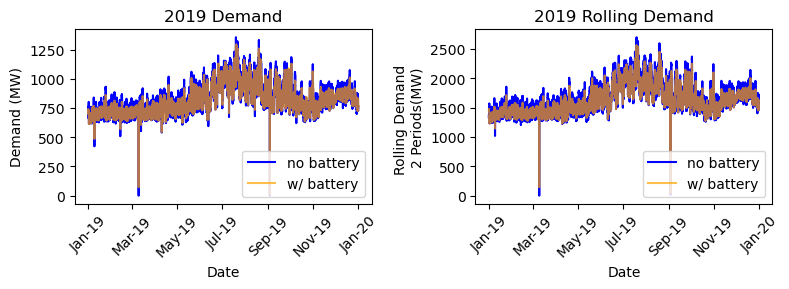

In [27]:
_ = plt.figure(figsize=(8,3))
#Plot Demand before and after battery
_ = plt.subplot(1,2,1)
_ =plt.plot(year_operation['timestamp'], year_operation['demand'], color='blue', label='no battery')
_ = plt.plot(year_operation['timestamp'], year_operation['demand'] - year_operation['discharge'] + year_operation['charge'], color='orange',alpha=.7, label='w/ battery')
_ = plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
_ = plt.xticks(rotation=45)
_ = plt.legend()
_ = plt.title('2019 Demand')
_ = plt.xlabel('Date')
_ = plt.ylabel('Demand (MW)')

_ = plt.subplot(1,2,2)
#Plot Demand before and after battery
_ =plt.plot(year_operation['timestamp'], year_operation['demand'].rolling(2).sum(), color='blue', label='no battery')
_ = plt.plot(year_operation['timestamp'], (year_operation['demand'] - year_operation['discharge'] + year_operation['charge']).rolling(2).sum(), color='orange',alpha=.7, label='w/ battery')
_ = plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
_ = plt.xticks(rotation=45)
_ = plt.legend()
_ = plt.title('2019 Rolling Demand')
_ = plt.xlabel('Date')
_ = plt.ylabel('Rolling Demand \n2 Periods(MW)')
_ = plt.tight_layout()

In [28]:
#Save results
year_results.to_csv('./data/2019_results/lithium_ion_290kW.csv')

In [29]:
year_operation.to_csv('./data/2019_results/290kw_lithium_ion_operation.csv')